# Rationale Visualization

This notebook lets you visualize the results of the best model from our experiments.

## Setup

In [136]:
import pandas as pd
import seaborn as sns
from sklearn.metrics import f1_score, accuracy_score
from functools import partial
import numpy as np

In [137]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [10, 5]
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.titlesize'] = 24
plt.rcParams['figure.dpi'] = 300
pd.set_option("expand_frame_repr", True)
pd.set_option('display.max_colwidth', None)

In [138]:
DF = pd.read_pickle('artifacts/categorized_rationales.pkl')
NLI_LABELS = ['entailment', 'contradiction', 'neutral']

## Pattern Analysis

Our finetuned T5 model can accurately predict the correct natural language inference (NLI) label for most Circa instances in the relaxed label setting. It can also successfully generate faithful rationales, as measured by the high LAS score.

The question that arises is **does the model actually generate rationales based on natural language understanding (NLU)?** 

It looks like the answer to that question is, unfortunately, **no** because **almost all of the rationales follow a handful of distinct templates the model learned from the e-SNLI and CoS-E datasets**.

Some important points before we start:

1. We removed all the extra spaces, punctutations, and capitalization to make matching a little easier. So don't think the T5 model can't understand syntax. It's actually quite proficient!

### Examples of Templates

Let's look at some examples of the templates we found. All of the templates follow the pattern of `<blank> some syntactic pattern <blank> `. We are interested in how T5 fills in the blanks. There are roughly three categories of templates with decreasing complexity:

1. Complex logical templates with verbose statements like `<blank>  and <blank> are contradictory pieces of information` or `if <blank> then it is logical to conclude that <blank>`.
2. Naive logical templates with incredibly simple statements like `<blank> is not a <blank>` or `<blank> because <blank>`. We prefix those template names with `naive_`.
3. Parroting templates, where the model just generates some combination of the premise, hypothesis, and /or context. We prefix those template names with `parrot_`.

Any other form of rationale we label as `unique`.

In [139]:
DF.groupby('template').sample(n=1, random_state=5423)[['template', 'rationale']]

,template,rationale
3432,comparison,a lot of concerts is more than two
26088,contradictory,buying books is wasteful is contradictory to buy scifi books recently
8554,denying the consequent,just because y has just travelled from a different city to meet x does not mean that he likes downtown
8347,either or,one cannot drive and fly at the same time
20026,equality,thank goodness is a form of expressing already
10137,implication,if karen is there it is implied that she is there to meet up with her family
7707,naive_assignment,tame impala is a band from tame impala
2775,naive_conditional,i like to hear orchestras play because i love hearing all the different instruments live
22459,naive_negation,walking is not driving
6406,only_option,rock is the only style of music i care about


### What proportion of the rationales can we account for with these templates?

In [140]:
num_naive = DF['template'].apply(lambda x: 'naive' in x).sum()
num_parrot = DF['template'].apply(lambda x: 'parrot' in x).sum()
num_unique = DF['template'].apply(lambda x: x == 'unique').sum()
total = len(DF)

print(f'Complex: {round((total - num_naive - num_parrot - num_unique)/total, 2) * 100}%')
print(f'Naive: {round(num_naive/total, 2) * 100}%')
print(f'Parrot: {round(num_parrot/total, 2) * 100}%')
print(f'Unique: {round(num_unique/total, 2) * 100}%')

Complex: 41.0%
Naive: 50.0%
Parrot: 1.0%
Unique: 8.0%


We can account for almost all of the rationales with the three template types. Crucially, the `complex` templates are quite frequent, which is important because these templates have longer natural language phrases. Therefore, the **plausibility** of the `complex` rationales is probably higher than the `naive` ones.

### When does the model apply each template?

Text(0.5, 1.0, 'Distribution of the Templates by Predicted Label - Entire Dataset')

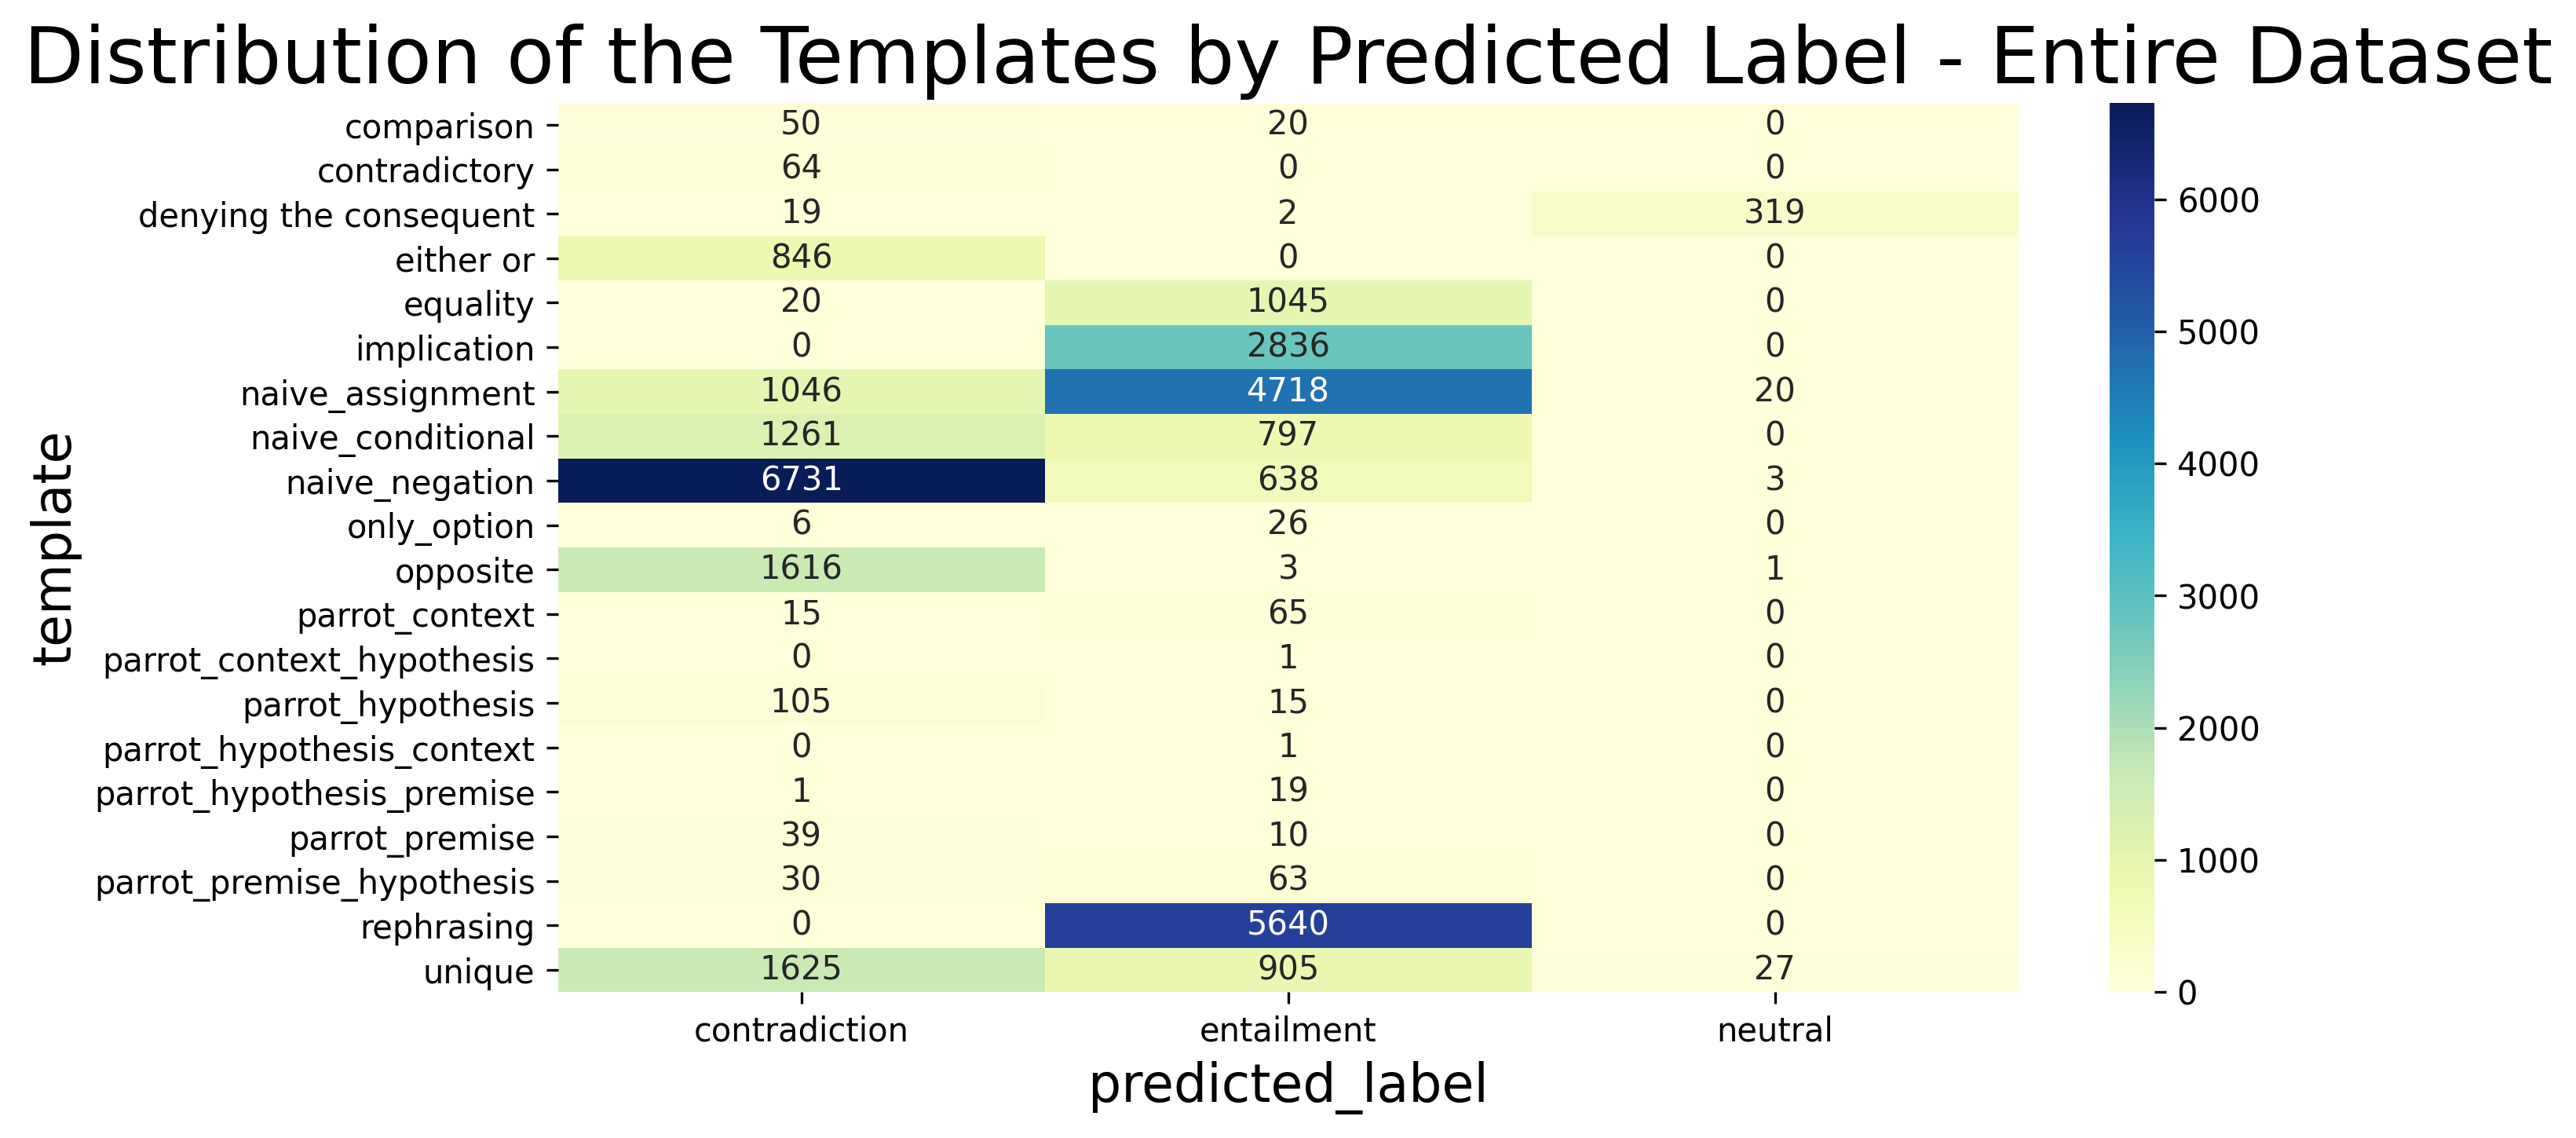

In [141]:
PATTERN_FREQUENCY = DF.groupby(['template', 'predicted_label']).size().reset_index()
PATTERN_FREQUENCY.columns = ['template', 'predicted_label', 'count']

PF_PIVOT = PATTERN_FREQUENCY.pivot('template', 'predicted_label', 'count')
PF_PIVOT[NLI_LABELS] = PF_PIVOT[NLI_LABELS].replace(np.nan, 0)
PF_PIVOT[NLI_LABELS] = PF_PIVOT[NLI_LABELS].astype(int)

ax = sns.heatmap(
    PF_PIVOT,
    annot=True,
    fmt='d',
    cmap='YlGnBu'
)
ax.set_title("Distribution of the Templates by Predicted Label - Entire Dataset")

The model's decision to apply a template largely depends on the label prediction. For example, `negation` is almost exclusively applied when the label is `contradiction`. And `assignment`, `implication`, and `rephrasing` are all applied when the label is `entailment`. Interestingly, **one template accounts for allmost all the `neutral` cases.** This template is a type of logical thinking called [denying the consequent, or 'modus tollens'](https://en.wikipedia.org/wiki/Modus_tollens). Maybe this is the only way to explain the `neutral` case? Or maybe this is just a consequence of the crowdsourced nature of the rationales in the e-SNLI and Cos-E datasets.

### Does the model actually understand these templates?

To answer this question, let's look at the distribution of templates by predicted label on the held out test set, as well as the micro f1 score by template.



Text(0.5, 1.0, 'Distribution of the Templates by Predicted Label - Test Set')

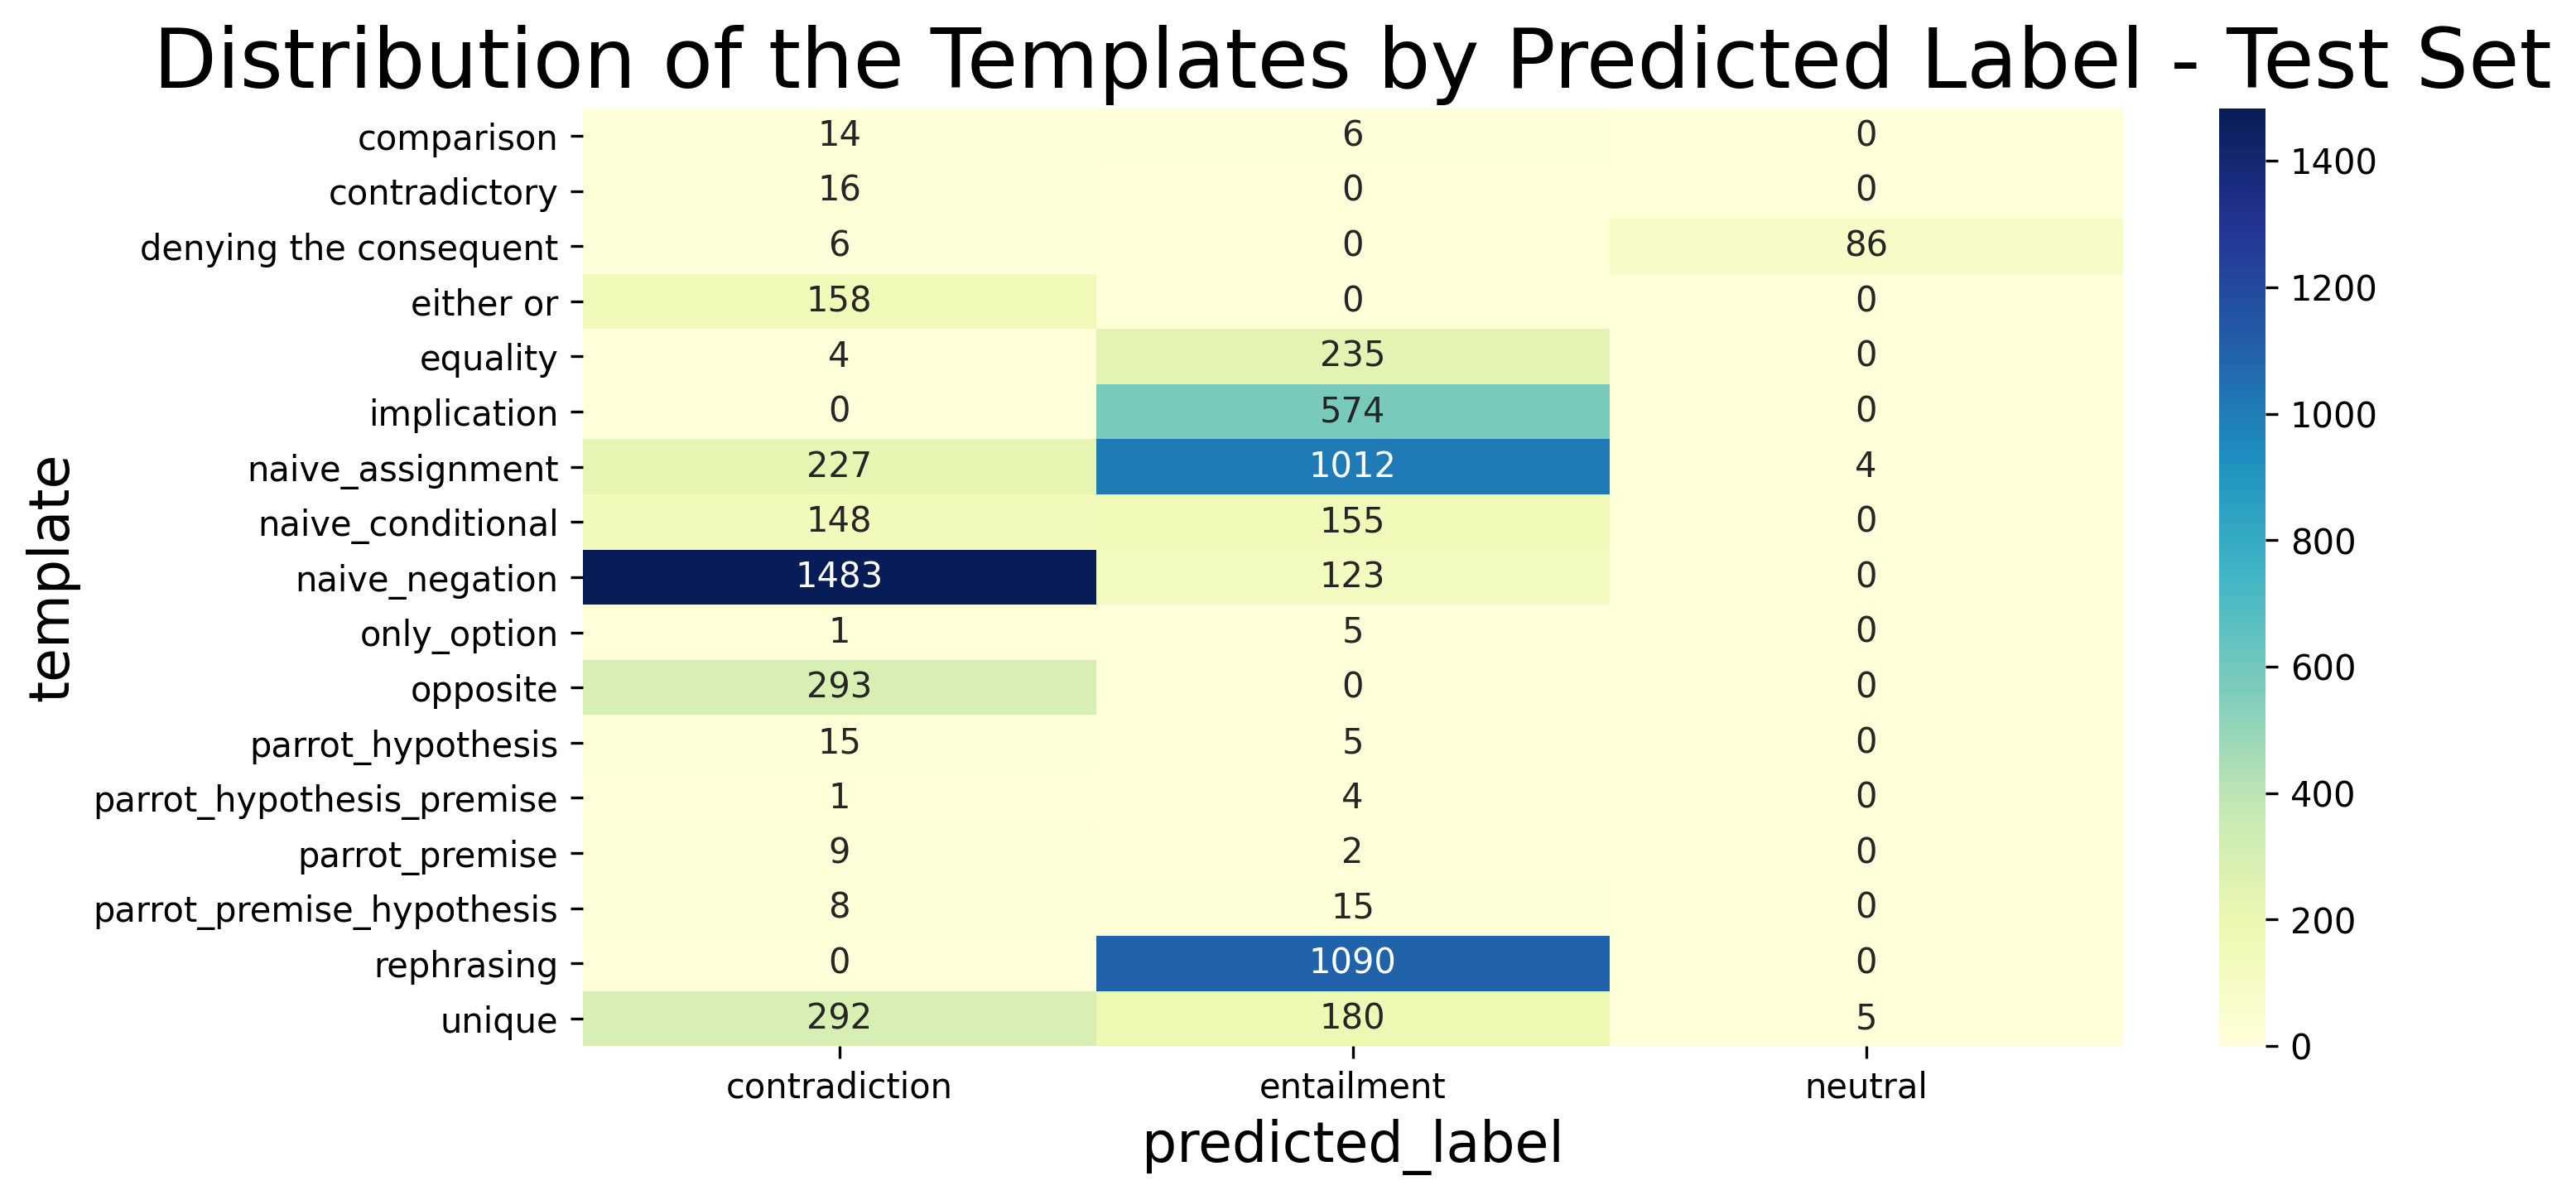

In [142]:
PATTERN_FREQUENCY = DF[DF['split'] == 'test'].groupby(['template', 'predicted_label']).size().reset_index()
PATTERN_FREQUENCY.columns = ['template', 'predicted_label', 'count']

PF_PIVOT = PATTERN_FREQUENCY.pivot('template', 'predicted_label', 'count')
PF_PIVOT[NLI_LABELS] = PF_PIVOT[NLI_LABELS].replace(np.nan, 0)
PF_PIVOT[NLI_LABELS] = PF_PIVOT[NLI_LABELS].astype(int)

ax = sns.heatmap(
    PF_PIVOT,
    annot=True,
    fmt='d',
    cmap='YlGnBu'
)
ax.set_title("Distribution of the Templates by Predicted Label - Test Set")

Text(0.5, 1.0, 'F1 Score by Predicted Label - Test Set')

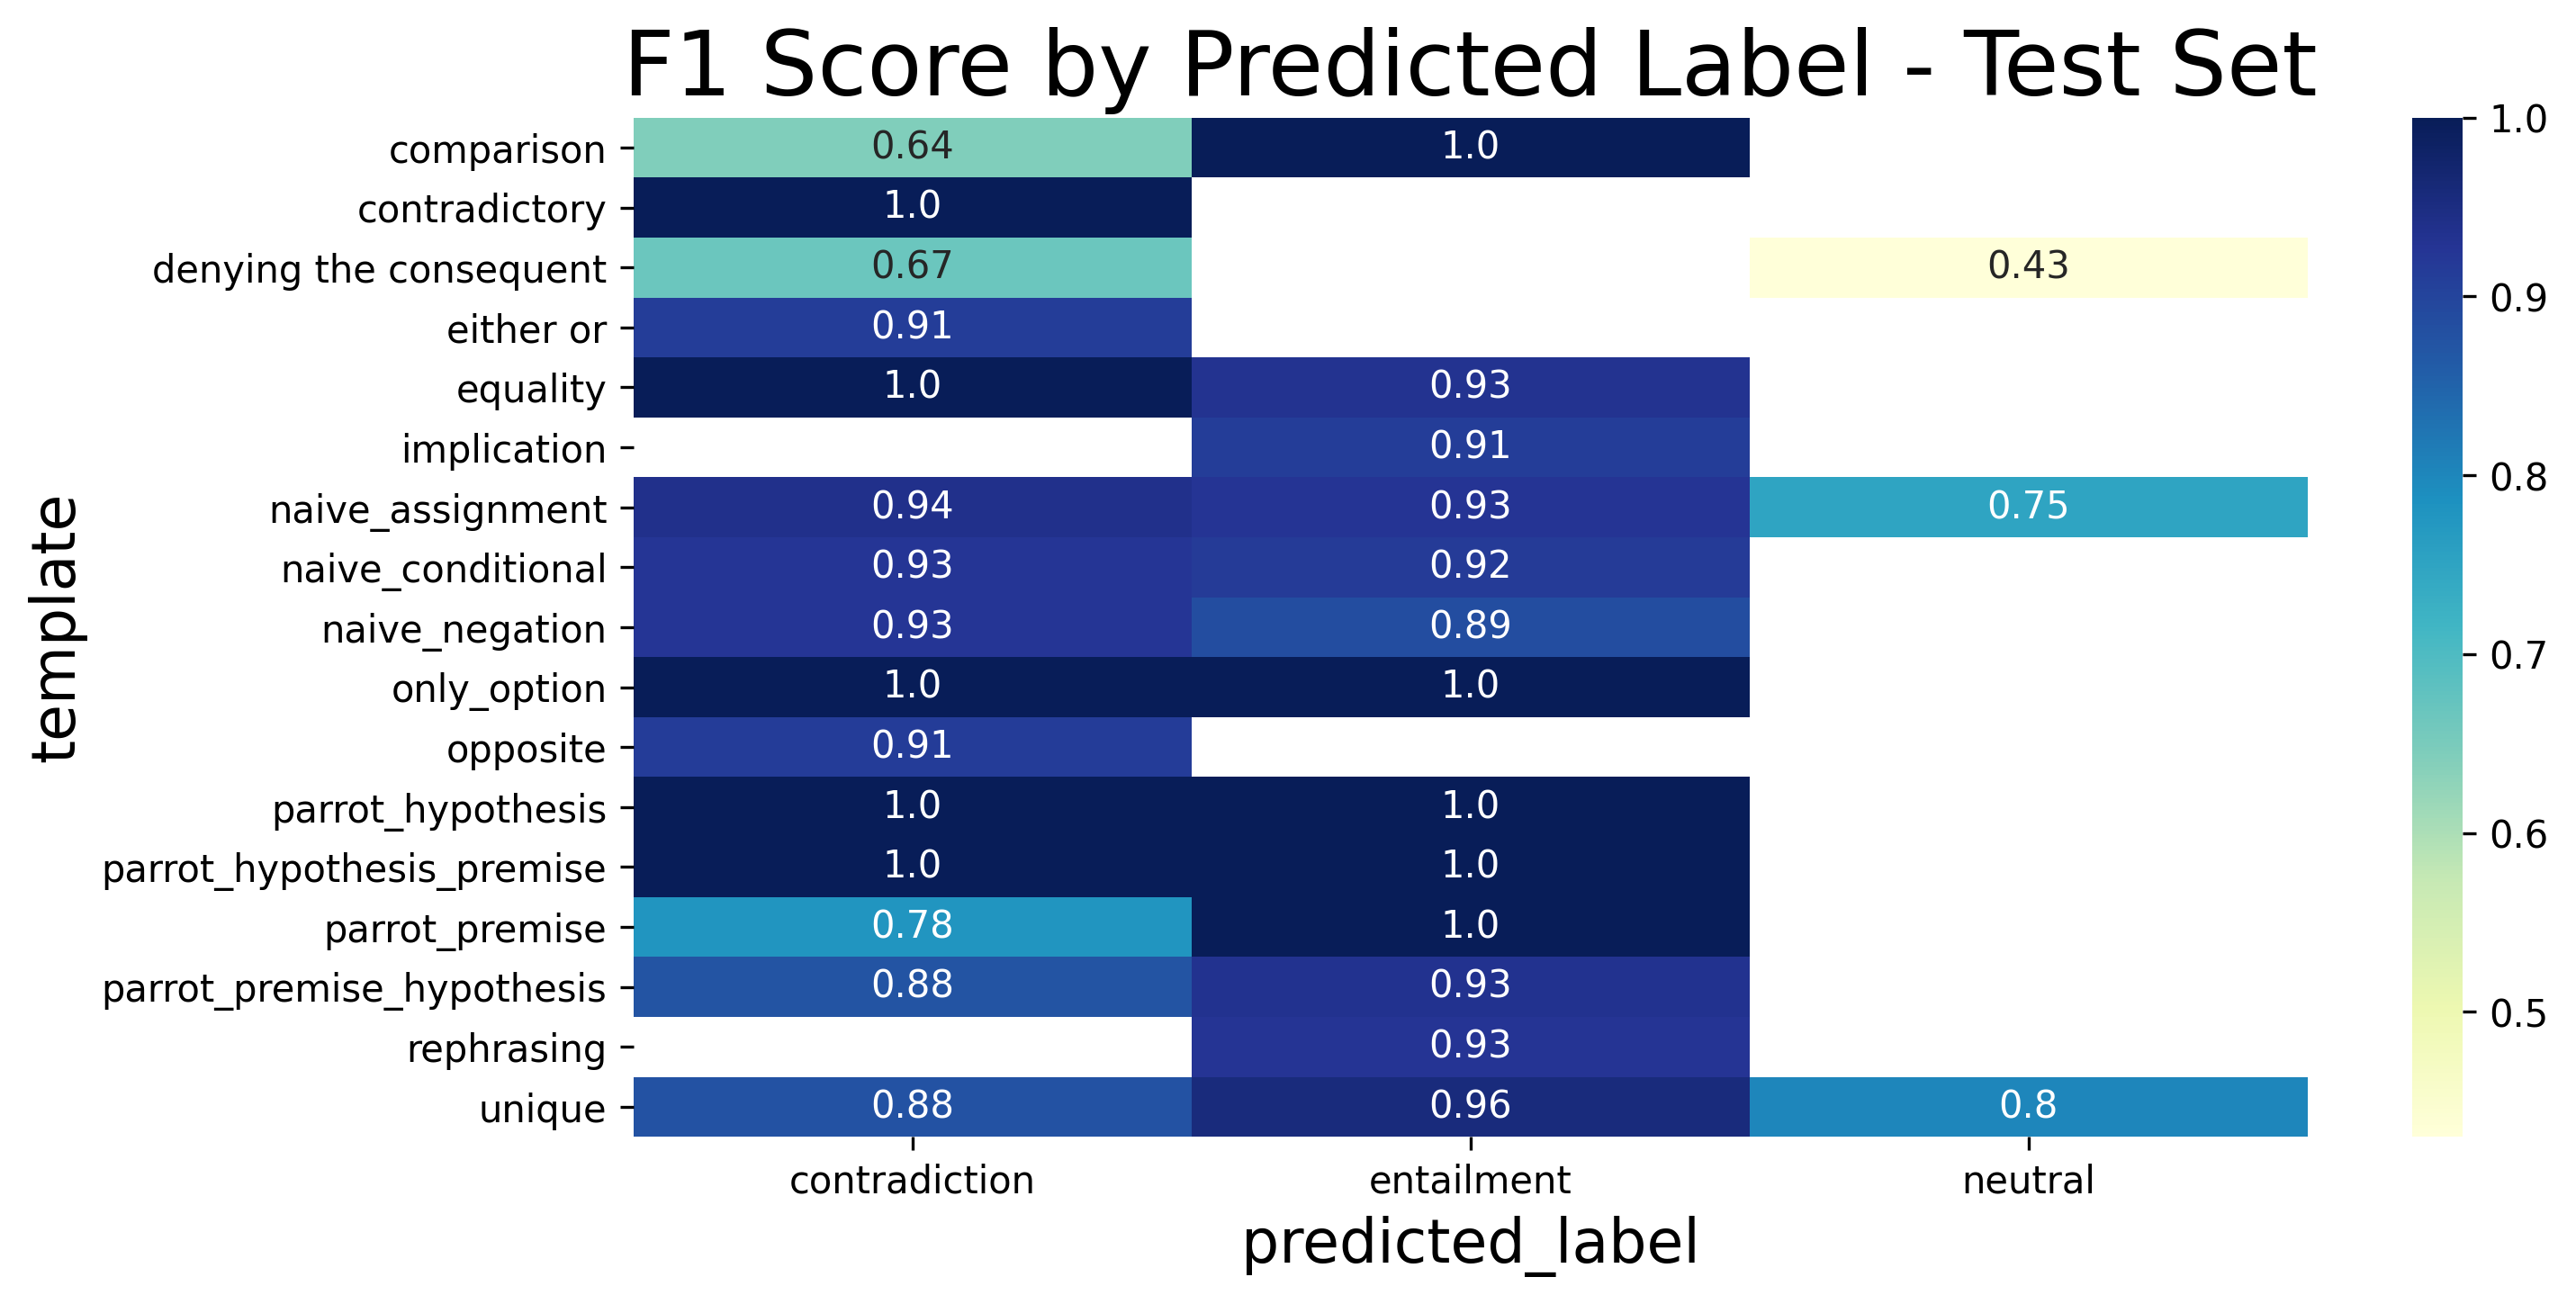

In [143]:
MICRO_F1 =  DF.groupby(['template', 'split', 'predicted_label']).apply(
    lambda x: f1_score(
        x['target_label'],
        x['predicted_label'],
        labels=['entailment', 'contradiction', 'neutral'],
        average='micro')
).rename('f1').reset_index()

A = MICRO_F1[MICRO_F1['split'] == 'test'].pivot('template', 'predicted_label', 'f1')
ax = sns.heatmap(
    A,
    annot=True,
    fmt='.2',
    cmap='YlGnBu'
)
ax.set_title("F1 Score by Predicted Label - Test Set")

The template distribution for the test set is a little denser. Most of the mistakes fall into two categories:

1. Innapropriately using `naive_assignment` or `naive_conditional` for the `contradiction` case.
2. Innapropriately using `naive_negation` for the `entailment` case.

The F1 scores are still high despite the innapropriate ussage of some templates in some cases. This is an unfortunate consequence of the transfer learning setup: **the model doesn't receive any supervision on which templates are appopriate for which labels on the Circa dataset**.

### How faithful are these templates?

A rationale is **faithful** when it accurately describes the reasoning process of the model. We have two ways of measuring **faithfulness**:

1. **Leakage-Adjusted Simulatibility (LAS)**, which measures "how well an observer can use model explanations to predict the model’s output, while controlling for explanation leakage" [(Hase et al., 2020)](https://www.aclweb.org/anthology/2020.findings-emnlp.390).

2. **Human judgments of quality**, which we obtain by asking participants on Mechanical Turk to rate the quality of rationales on a Likert scale.

#### LAS 

Let's start with LAS. We train a DistilBERT model to predict the correct NLI label given a) just the circa input or b) the input **AND** the T5-generated rationale.Do some templates leak (give away) the correct answer more than others?

Text(0.5, 1.0, 'Leakage by Template - All T5 Rationales')

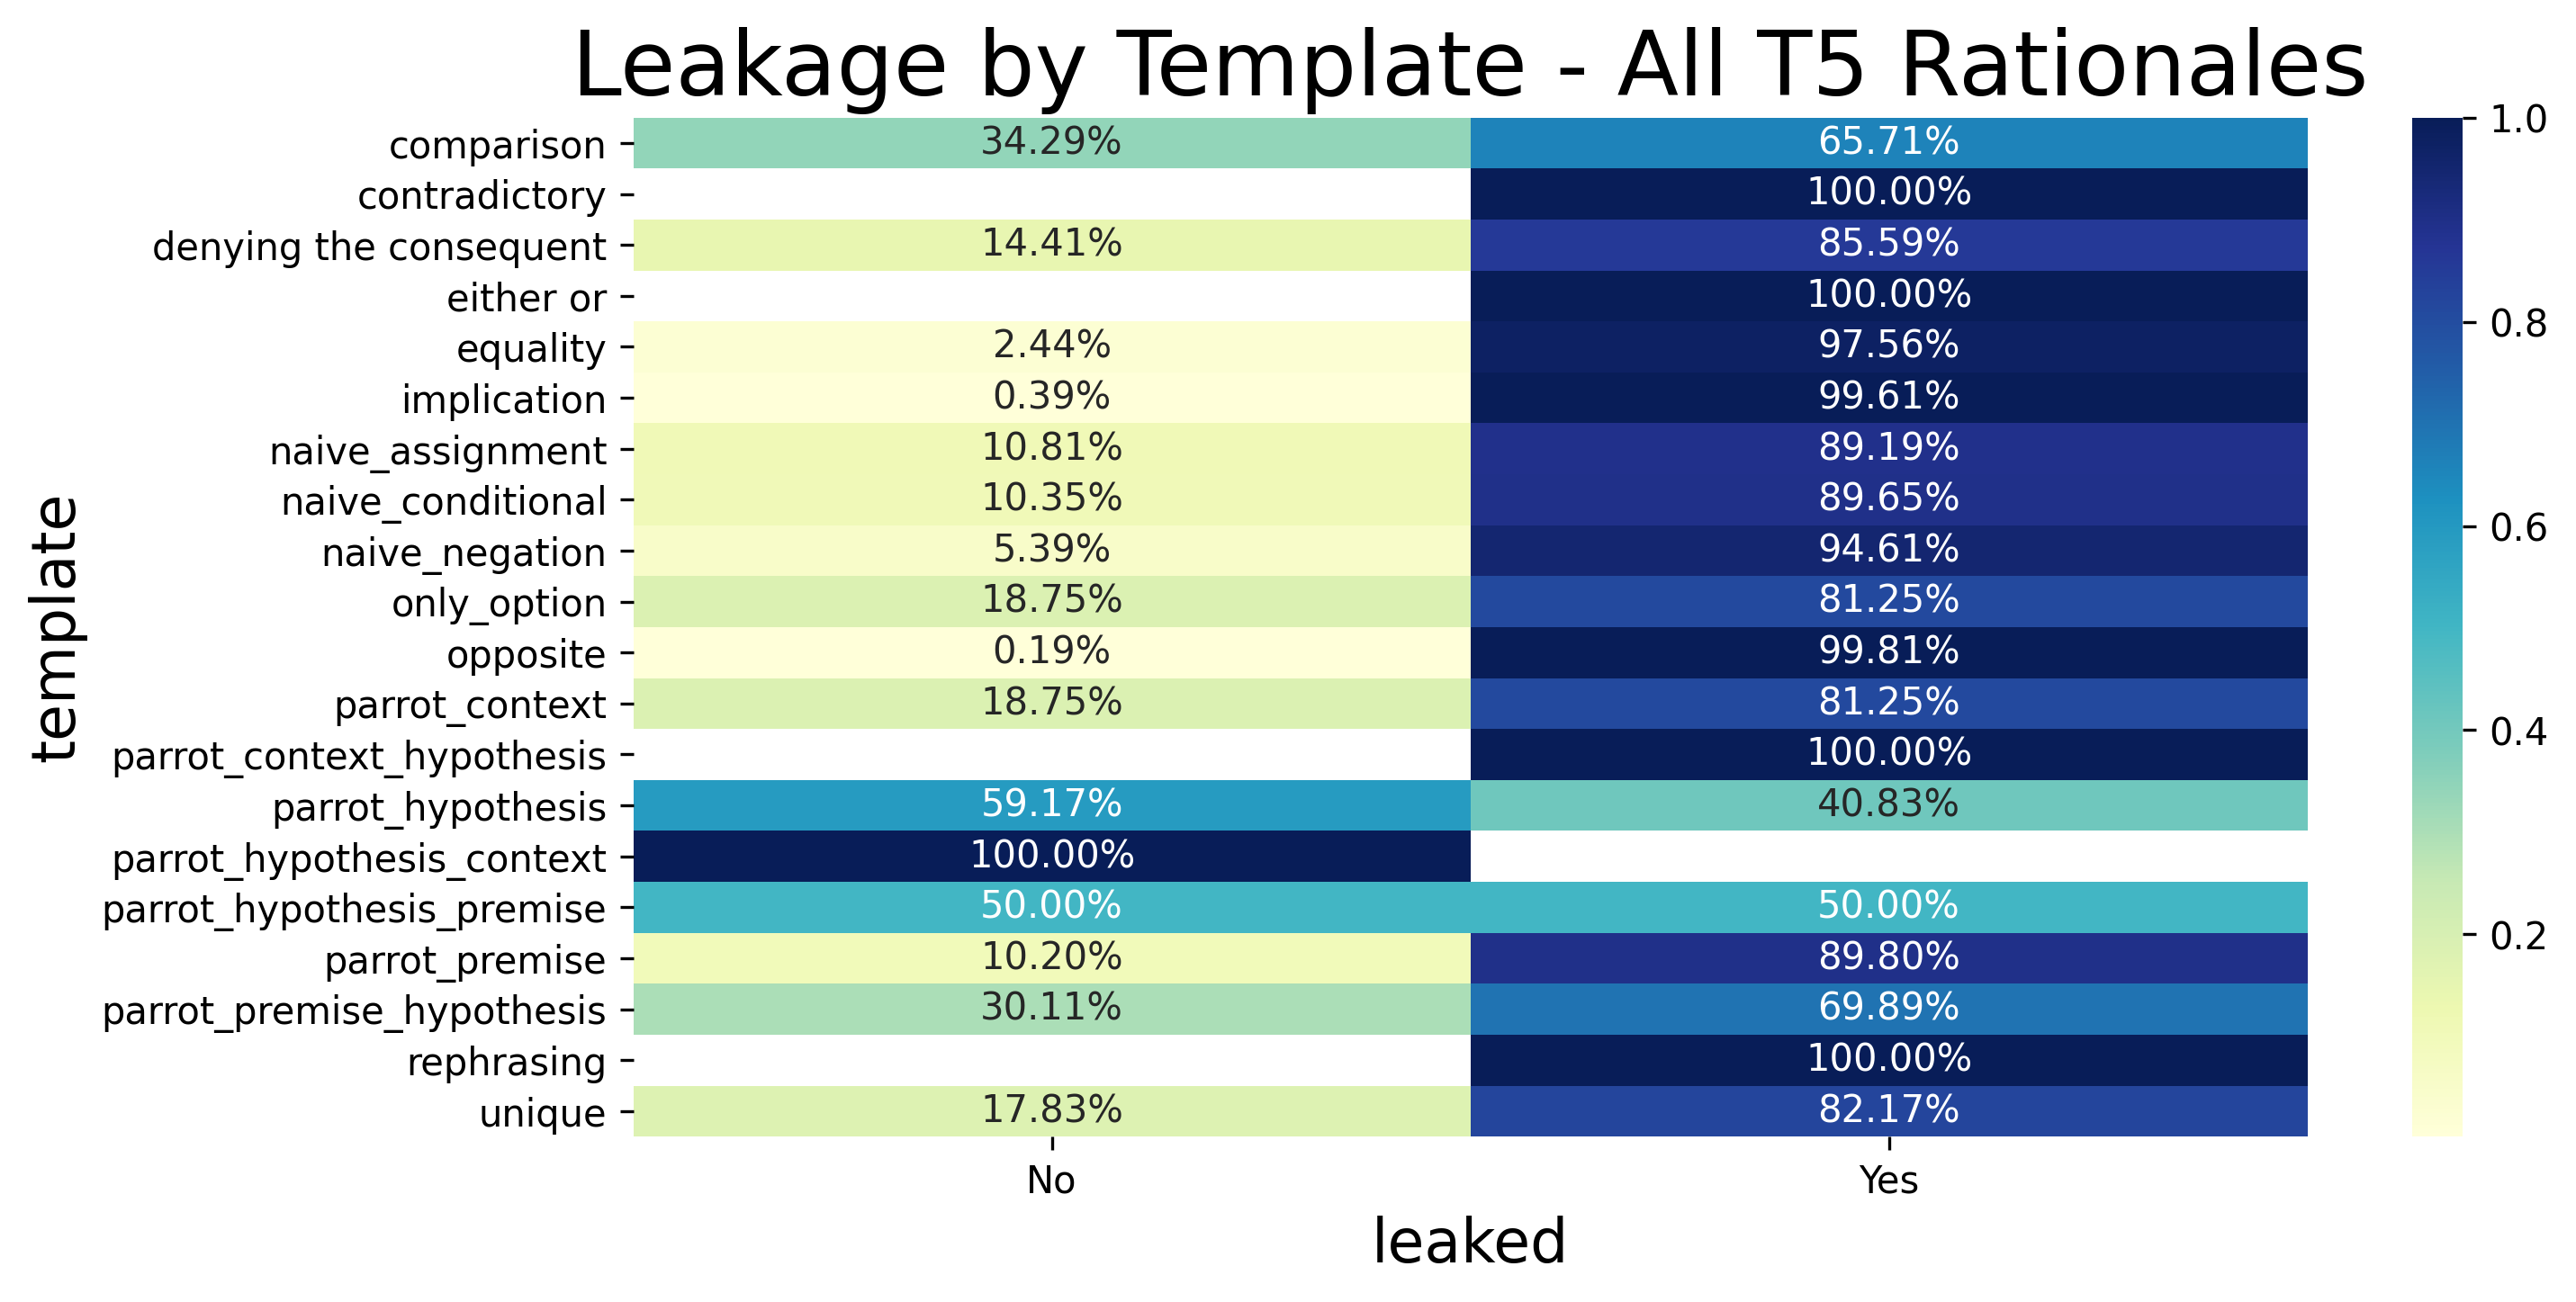

In [144]:
LEAKAGE_BY_PATTERN = (DF.groupby(['template'])['leaked'].value_counts(normalize=True)).to_frame()
LEAKAGE_BY_PATTERN.columns = ['percent_leaked']
LEAKAGE_BY_PATTERN = LEAKAGE_BY_PATTERN.reset_index()
LEAKAGE_BY_PATTERN.columns = ['template', 'leaked', 'percent_leaked']
LEAKAGE_BY_PATTERN = LEAKAGE_BY_PATTERN.pivot('template', 'leaked', 'percent_leaked')
ax = sns.heatmap(
    LEAKAGE_BY_PATTERN,
    annot=True,
    fmt='.2%',
    cmap='YlGnBu'
)
ax.set_title("Leakage by Template - All T5 Rationales")

It looks like most templates do, in fact, leak the label. They may not directly state `entailment`, `contradiction`, or `neutral`, but they follow such a predictable pattern that DistilBERT can easily tell what the correct label is. 

We observe some interesting trends:

1. Parroting the premise commonly leads to leakage. This makes sense. The indirect answers are easy to classify even without knowledge of the original question.
1.The **comparison** and **only option** templates tend to leak the least of all non-parroting lables. Perhaps this is because DistilBERT struggles with comparison and quantifiers like `only`?

#### Rationale Quality

It's also worth looking at the average annotator rating per template to see if people prefer some templates over others.

[Text(0.5, 0, 'Average Quality (Number of Ratings)'),
 Text(0, 0.5, 'Template'),
 Text(0.5, 1.0, 'Average Quality by Template')]

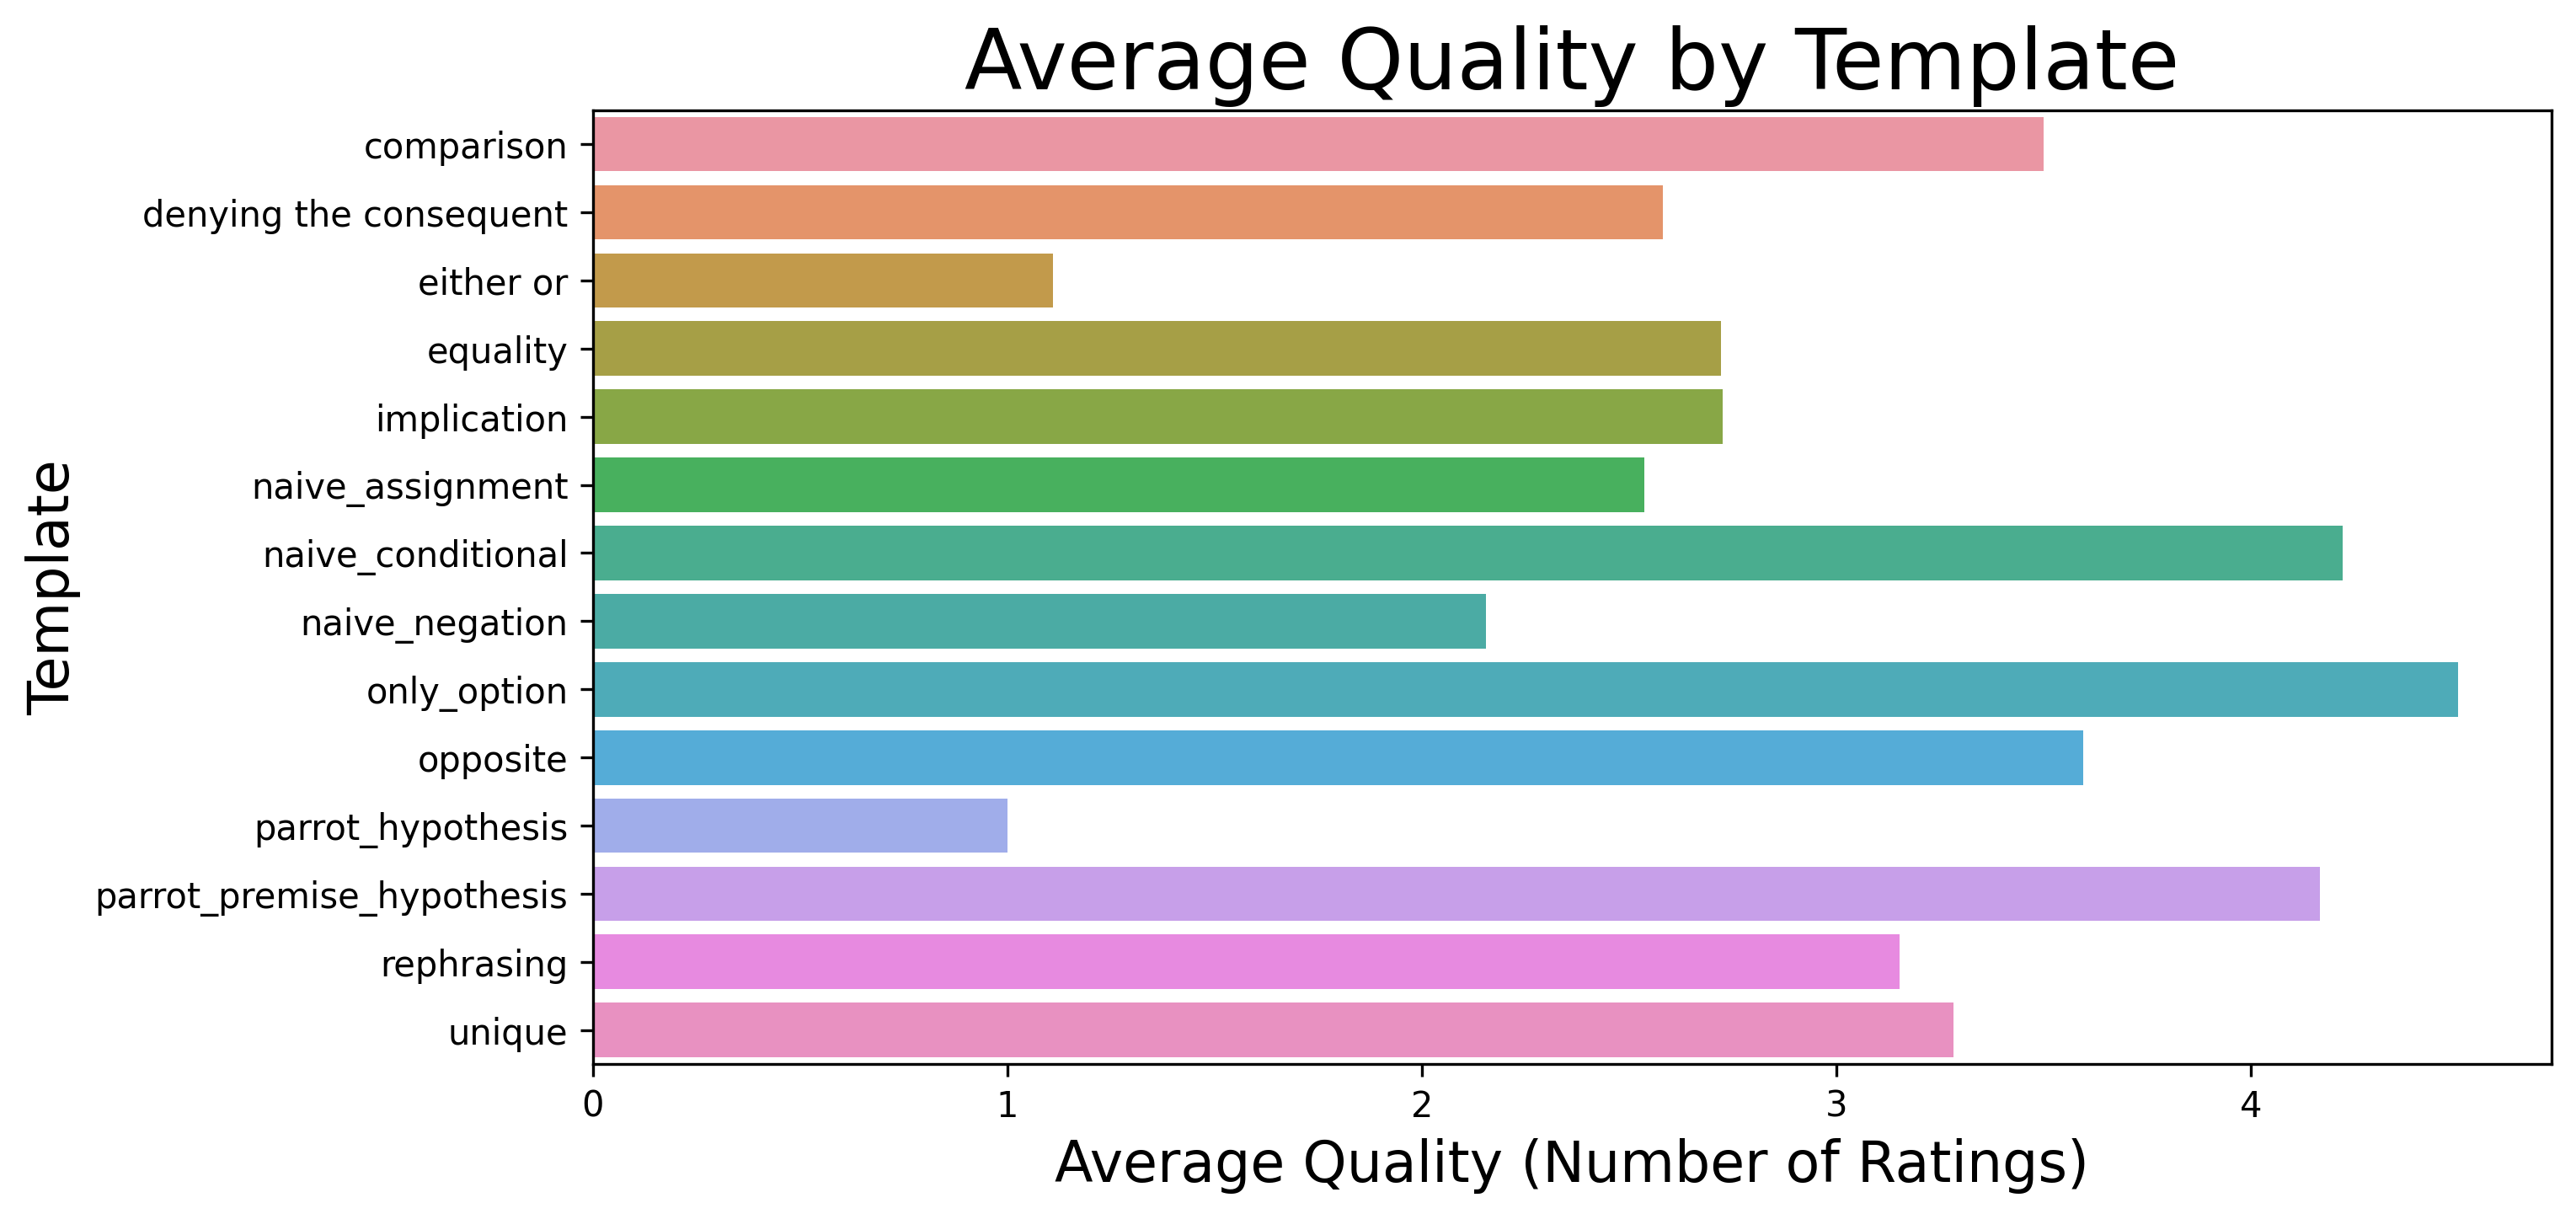

In [145]:
QUALITY_BY_PATTERN = DF.groupby(['template'])['quality'].aggregate(['mean', 'count']).reset_index()
QUALITY_BY_PATTERN = QUALITY_BY_PATTERN.dropna()

splot = sns.barplot(
    y='template',
    x='mean',
    data=QUALITY_BY_PATTERN,
)

splot.set(
    xlabel='Average Quality (Number of Ratings)',
    ylabel='Template',
    title='Average Quality by Template'
)

We don't have many ratings, so there isn't an obvious pattern here. In future work, we would like to collect more annotations.

### How free-form are the rationales?

Does the model just blindly substitute in some combination of the hypothesis, premise, and/or context into the templates? Or does it change existing words or add new ones?

To check this, we can see how often the regex capture groups of our model exactly match part of the input.

In [133]:
def unique_label_for_spans(span1, span2):
    span1 = span1 if isinstance(span1, tuple) else (span1,)
    span2 = span2 if isinstance(span2, tuple) else (span2,)
    s1 = " + ".join([i if i is not None else 'unique' for i in span1])
    if s1 == 'unique + unique':
        s1 = 'unique'
    s2 = " + ".join([i if i is not None else 'unique' for i in span2])
    if s2 == 'unique + unique':
        s2 = 'unique'
    return f'({s1}, {s2})'

<AxesSubplot:xlabel='substitution', ylabel='template'>

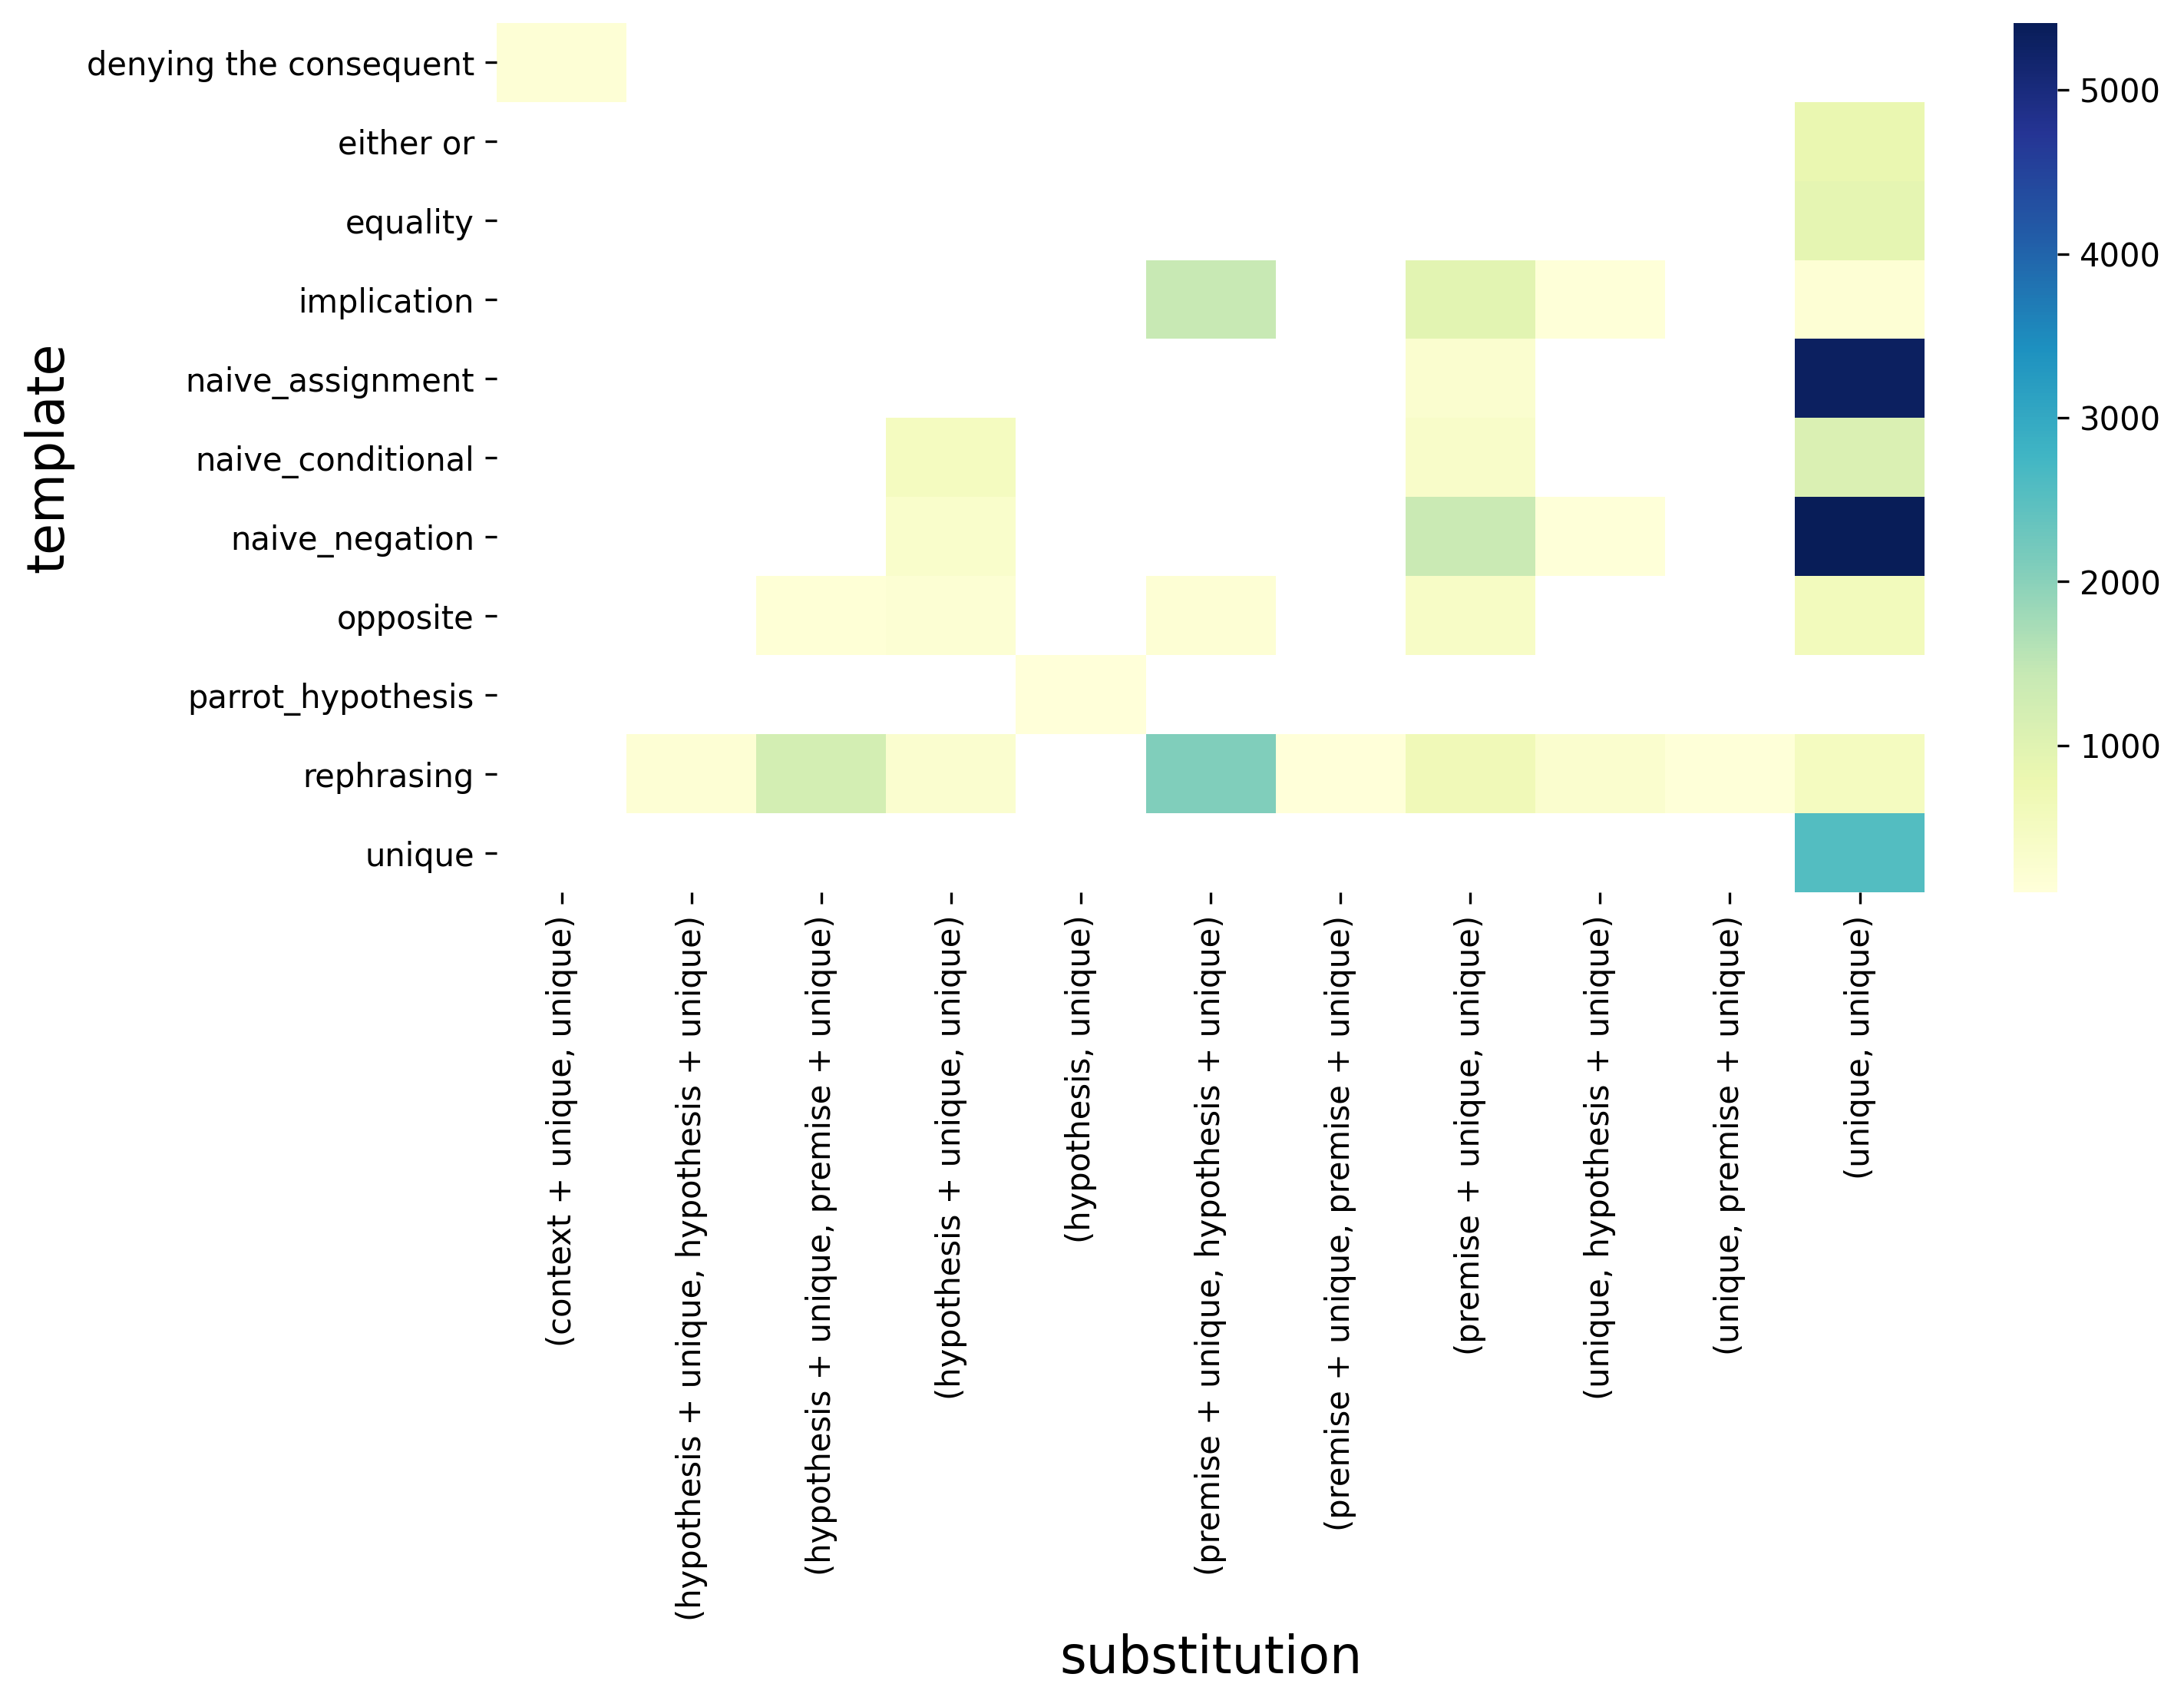

In [147]:
SPAN_PATTERN_BY_LABEL = DF.copy()
# SPAN_PATTERN_BY_LABEL = SPAN_PATTERN_BY_LABEL[SPAN_PATTERN_BY_LABEL['split'] == 'test']
SPAN_PATTERN_BY_LABEL['substitution'] = SPAN_PATTERN_BY_LABEL.apply(
    lambda x: unique_label_for_spans(x.span1_label, x.span2_label), 
    axis=1
)
SPAN_PATTERN_BY_LABEL = SPAN_PATTERN_BY_LABEL.groupby(['substitution', 'template']).size().reset_index()
SPAN_PATTERN_BY_LABEL.columns = ['substitution', 'template', 'count']
SPAN_PATTERN_BY_LABEL = SPAN_PATTERN_BY_LABEL[SPAN_PATTERN_BY_LABEL['count'] > 100]
SPAN_PATTERN_BY_LABEL = SPAN_PATTERN_BY_LABEL.pivot('template', 'substitution', 'count')
sns.heatmap(
    SPAN_PATTERN_BY_LABEL,
    cmap='YlGnBu',
)

So the majority of the time the model is actually adding new text or modifying existing text when generating rationales! When it does blindly substititute some part of the input, it is usually subtituting the premise plus some tokens into the first capture group, and the hypothesis plus some tokens into the second capture group. This is more evidence that model understands how to correctly format logical statements, even if the truth value of that statement clashes with the intepretation of the indirect answer.